# Convolutional Neural Networsk Project

In [2]:
# Import libraries that are used in notebook
import torch
from torchvision import transforms
from torch import optim

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import random
import seaborn as sns

import torch.nn as nn
from tensorflow.keras.preprocessing import image_dataset_from_directory
from torchvision import datasets, transforms
import os
from torch.utils.data import DataLoader, random_split

## Sub-project 1:

## Solve Fashion_MNIST with LeNet architecture

In this project you will implement the LeNet architecture of Convolutional Neural Networks. First you will download the Fashion-MNIST dataset. Split into train/validation/test datasets and train the network. Finally, plot the learning curves (train/validation loss and accuracy) and show the confusion matrix.

### 1. Download Fashion-MNIST

In [3]:
# Download data
from keras.datasets import fashion_mnist

# Load the fashion_mnist dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Create X_Val from X_train
X_Val = X_train[50000:]  # Take the last 10,000 images as the validation set
y_val = y_train[50000:]
X_train = X_train[:50000]  # Use the first 50,000 images as the training set
y_train = y_train[:50000]

# Convert to PyTorch tensors
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

X_train = torch.stack([transform(img) for img in X_train])
X_Val = torch.stack([transform(img) for img in X_Val])
X_test = torch.stack([transform(img) for img in X_test])

# Create the PyTorch datasets
train_data = torch.utils.data.TensorDataset(X_train, torch.tensor(y_train))
val_data = torch.utils.data.TensorDataset(X_Val, torch.tensor(y_val))
test_data = torch.utils.data.TensorDataset(X_test, torch.tensor(y_test))

In [4]:
# Inspect data by looking at its length
print("Lenght of training data:", len(train_data))
print("Lenght of test data:", len(test_data))
print("Lenght of validation data:", len(val_data))

Lenght of training data: 50000
Lenght of test data: 10000
Lenght of validation data: 10000


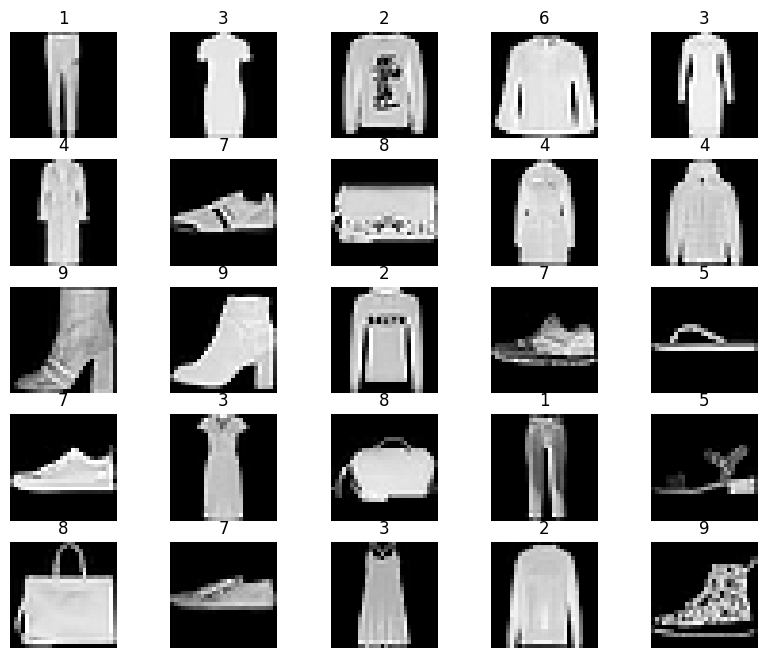

In [5]:
# Visualize a few images
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label.item())  # Show only the label number as a plain Python integer
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

 ### 2. Split the data into train / validation / test subsets. Make mini-batches, if necesssary.

Split into subsets see 1.

In [6]:
# Create Mini-batches to train an epoch on a smaller random sample of the training data to avoid overfitting and improve the performance with large datasets
from torch.utils.data import DataLoader

loaders = {
    'train' : torch.utils.data.DataLoader(train_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),

    'validation'  : torch.utils.data.DataLoader(val_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),

    'test'  : torch.utils.data.DataLoader(test_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),
}

In [7]:
# Normalizing training data

# Define a function to calculate the mean and standard deviation of the training dataset
def batch_mean_and_sd(loader):
    cnt = 0
    fst_moment = torch.empty(1)
    snd_moment = torch.empty(1)

    for images, _ in loader:
        nb_pixels = images.numel()  # Total number of pixels in the batch
        sum_ = torch.sum(images)
        sum_of_square = torch.sum(images ** 2)
        fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)
        cnt += nb_pixels

    mean, std = fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)
    return mean, std

# Calculate mean and standard deviation of training data
mean, std = batch_mean_and_sd(loaders['train'])
print("Mean and Std: ", mean, std)

# Normalize the training data using the calculated mean and standard deviation
transform_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std]),
])

X_train_normalized = torch.stack([transform_normalize(img) for img in X_train])
X_test_normalized = torch.stack([transform_normalize(img) for img in X_test])

# Create the PyTorch datasets
train_data = torch.utils.data.TensorDataset(X_train_normalized, torch.tensor(y_train))
test_data = torch.utils.data.TensorDataset(X_test_normalized, torch.tensor(y_test))

# Normalize the validation data using the same mean and standard deviation
X_val_normalized = torch.stack([transform_normalize(img) for img in X_Val])

# Create the PyTorch dataset for validation
val_data = torch.utils.data.TensorDataset(X_val_normalized, torch.tensor(y_val))

Mean and Std:  tensor([0.2855]) tensor([0.3528])


In [8]:
# Create Mini-batches to train an epoch on a smaller random sample of the training data to avoid overfitting and improve the performance with large datasets
from torch.utils.data import DataLoader

loaders = {
    'train' : torch.utils.data.DataLoader(train_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),

    'validation'  : torch.utils.data.DataLoader(val_data,
                                          batch_size=100,
                                          shuffle=False,
                                          num_workers=1),

    'test'  : torch.utils.data.DataLoader(test_data,
                                          batch_size=100,
                                          shuffle=False,
                                          num_workers=1),
}

### 3. Build the LeNet model

In [9]:
def LeNet_model():
  """
  Creates a LeNet-5 model architecture.
  Returns:
    nn.Sequential: LeNet model consisting of convolutional and fully connected layers for a 28*28 pixcel image.
  """
  return nn.Sequential(
        nn.Conv2d(1, 6, 5, 1, 2), # first convolutional layer: 1 input image channel, 6 output channels, 5x5 kernel size
        nn.ReLU(),  # ReLU activation Function to intoduce non-linearity
        nn.MaxPool2d(2, 2),  # 2x2 max pooling
        nn.Conv2d(6, 16, 5, 1, 0),  # second convolutional layer: 6 in, 16 out, 5x5 kernel
        nn.ReLU(),  # ReLU activation function
        nn.MaxPool2d(2, 2),  # 2x2 max pooling
        nn.Flatten(),  # Flatten to 1D tensor
        nn.Linear(16 * 5 * 5, 120),  # Fully connected  layer (16*5*5 -> 120)
        nn.ReLU(),  # ReLU activation function
        nn.Linear(120, 84),  # Fully connected layer (120 -> 84)
        nn.ReLU(),  # ReLU activation
        nn.Linear(84, 10),  # Fully connected  layer that returns one of the 10 possible classes as label (84 -> 10) (Softmax calculated internally)
    )


**Note**
There have been made some adjustments to the original architecture due to better performance:
* The pooling layers have been changed to **Max Pooling instead of Average Pooling**. The better results can be explained like this: Max pooling selects the maximum value from a group of neighboring pixels in a pooling window. It helps to retain important features by emphasizing the most significant information. To the contrary, average pooling calculates the average value of pixels in a pooling window. It can lead to a loss of important details, especially in regions with varying intensity. Thus, max pooling tends to preserve sharper edges and stronger features, which can be helpful for object detection and recognition tasks. It helps prevent blurring of features that can occur with average pooling.

* **Instead of using sigmoid as activation function relu** was choosen. Relu activation function introduces non-linearity by mapping negative input values to zero and leaving positive values unchanged. It is known for its ability to mitigate the vanishing gradient problem and accelerate training. Sigmoid activation function maps input values to a range between 0 and 1. While it can squash input values and provide non-linearity, it suffers from vanishing gradient and gradient saturation issues, particularly for deep networks.
In conclusion, ReLU allows the network to train faster by avoiding saturation and vanishing gradient issues. It enables better training of deep networks.

### 4. Train the model on the dataset

In [10]:
# Create function that trains the model with different hyperparameters as inputs, the model and loaders

def train(model, loaders, learning_rate=0.01, num_epochs=50, early_stopping_patience=5):
    """
    Train a neural network model using specified hyperparameters.

    Args:
        model (nn.Module): The neural network model to be trained.
        loaders (dict): A dictionary containing data loaders for training and validation datasets.
        learning_rate (float): The learning rate for the optimizer (default: 0.01).
        num_epochs (int): The number of training epochs (default: 50).
        early_stopping_patience (int): The number of epochs with no improvement after which training will be stopped (default: 5).

    Returns:
        train_losses (list): List of training losses for each epoch.
        val_losses (list): List of validation losses for each epoch.
        train_accuracies (list): List of training accuracies for each epoch.
        val_accuracies (list): List of validation accuracies for each epoch.
        best_val_accuracy (float): The highest validation accuracy achieved during training.
        best_epoch (int): The epoch with the highest validation accuracy.
    """

    loss_f = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    min_valid_loss = np.inf
    best_val_accuracy = 0
    best_epoch = 0
    train_losses = []
    val_losses = []
    val_accuracies = []
    train_accuracies = []

    if torch.cuda.is_available():
        model.cuda()

    # implement early stopping
    early_stopping_counter = 0
    early_stopping_threshold = 1e-4  # Minimum change in validation loss to consider as improvement

    for epoch in range(num_epochs):
        # Train the model
        epoch_train_loss = 0
        correct_train = 0
        total_train = 0

        # This line tells the NN that it's in the training mode
        model.train()
        for i, (images, labels) in enumerate(loaders['train']):
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()
            output = model(images)
            loss = loss_f(output, labels)
            epoch_train_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(output.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # clear gradients for this training step
            optimizer.zero_grad()

            # backpropagation, compute gradients
            loss.backward()
            # apply gradients
            optimizer.step()

        accuracy_train = correct_train / total_train
        train_accuracies.append(accuracy_train)

        # Validate the model
        epoch_val_loss = 0
        model.eval()
        with torch.no_grad():
            correct_val = 0
            total_val = 0
            for images_v, labels_v in loaders['validation']:
                if torch.cuda.is_available():
                    images_v, labels_v = images_v.cuda(), labels_v.cuda()
                output = model(images_v)
                loss_v = loss_f(output, labels_v)
                epoch_val_loss += loss_v.item()

                _, predicted = torch.max(output.data, 1)
                total_val += labels_v.size(0)
                correct_val += (predicted == labels_v).sum().item()

        accuracy_val = correct_val / total_val
        val_accuracies.append(accuracy_val)

        print(f'Epoch {epoch+1}')
        print(f'Training Loss: {epoch_train_loss / len(loaders["train"])}')
        print(f'Validation Loss: {epoch_val_loss / len(loaders["validation"])}')
        print(f'Training Accuracy: {accuracy_train}')
        print(f'Validation Accuracy: {accuracy_val}')
        print('-------------------')

        if min_valid_loss - epoch_val_loss > early_stopping_threshold:
            early_stopping_counter = 0
            min_valid_loss = epoch_val_loss
            # Saving State Dict (best model)
            torch.save(model.state_dict(), 'saved_model.pth')
        else:
            early_stopping_counter += 1

        if accuracy_val > best_val_accuracy:
            best_val_accuracy = accuracy_val
            best_epoch = epoch + 1

        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered. Stopping training.")
            break

        train_losses.append(epoch_train_loss / len(loaders["train"]))
        val_losses.append(epoch_val_loss / len(loaders["validation"]))

    return train_losses, val_losses, train_accuracies, val_accuracies, best_val_accuracy, best_epoch

In [11]:
# Creating a model
model = LeNet_model()

# Training model & returning losses and accuracies for validation and training data
train_losses, val_losses, train_accuracies, val_accuracies, best_val_accuracy, best_epoch  = train(model,loaders, learning_rate=0.001, num_epochs=50, early_stopping_patience=5)

Epoch 1
Training Loss: 0.6729249405860901
Validation Loss: 0.46162477761507037
Training Accuracy: 0.75462
Validation Accuracy: 0.8336
-------------------
Epoch 2
Training Loss: 0.4149872604906559
Validation Loss: 0.3881465382874012
Training Accuracy: 0.84798
Validation Accuracy: 0.8565
-------------------
Epoch 3
Training Loss: 0.3514651734530926
Validation Loss: 0.3335391469299793
Training Accuracy: 0.87132
Validation Accuracy: 0.8798
-------------------
Epoch 4
Training Loss: 0.31468338865041734
Validation Loss: 0.32163139298558235
Training Accuracy: 0.8844
Validation Accuracy: 0.8818
-------------------
Epoch 5
Training Loss: 0.2913842719197273
Validation Loss: 0.3244470465183258
Training Accuracy: 0.89326
Validation Accuracy: 0.8826
-------------------
Epoch 6
Training Loss: 0.2745915362238884
Validation Loss: 0.3135078313946724
Training Accuracy: 0.89858
Validation Accuracy: 0.8862
-------------------
Epoch 7
Training Loss: 0.254996750369668
Validation Loss: 0.2967526564002037
Tra

In [12]:
print("Best found validation accuracy:", best_val_accuracy, "Best epoch:", best_epoch )

Best found validation accuracy: 0.9053 Best epoch: 16


### 5. Plot the training curves (Loss and accuracy)

In [13]:
# Create a function for plotting the training curves
def plot_training_curve(train_losses, val_losses, train_accuracies, val_accuracies):
    """
    Plot training and validation loss and accuracy curves.

    Args:
        train_losses (list): List of training losses for each epoch.
        val_losses (list): List of validation losses for each epoch.
        train_accuracies (list): List of training accuracies for each epoch.
        val_accuracies (list): List of validation accuracies for each epoch.
    """
    plt.figure(figsize=(16, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

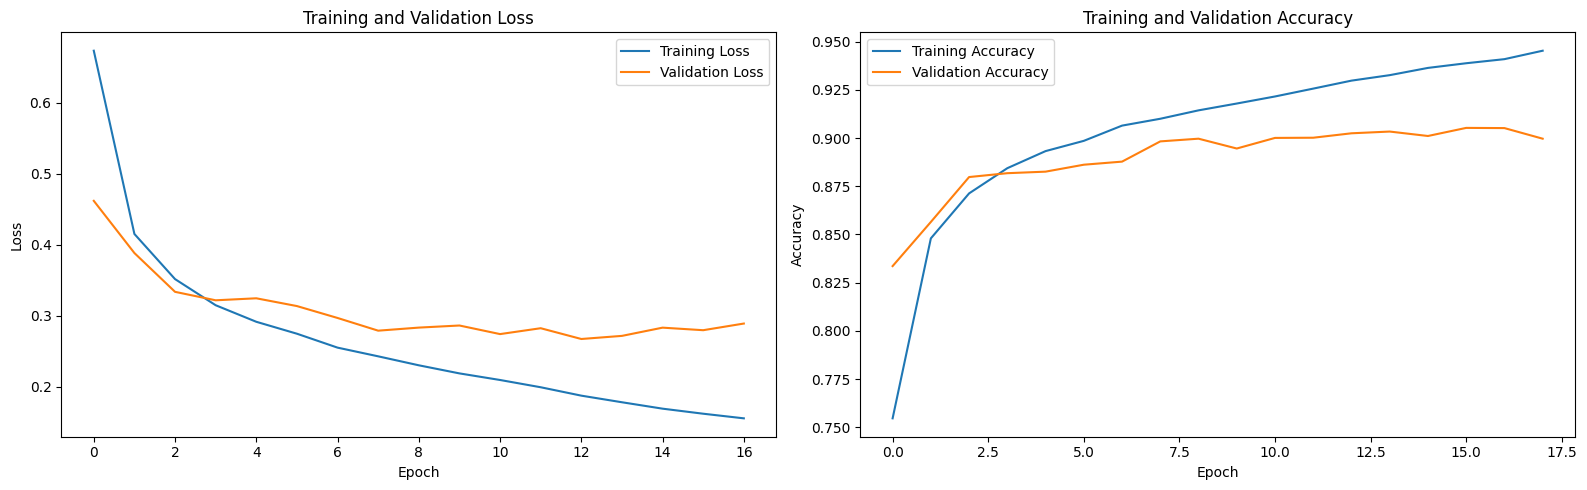

In [14]:
# Calling the function to show the training curves for the LeNet model
plot_training_curve(train_losses, val_losses, train_accuracies, val_accuracies)

### 6. Show the confusion matrix and accuracy on the test dataset.

In [15]:
# Define function with model and test data from loader as input, returns accuracy of test data
def evaluate_confusion_matrix(model, test_loader, label_nr):
    """
    Evaluate the accuracy of a trained model on test data and display the confusion matrix.

    Args:
        model (torch.nn.Module): The trained model.
        test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        label_nr (int): Number of labels/classes in the dataset.

    Returns:
        float: Test accuracy.
    """
    if torch.cuda.is_available():
        model.cuda()
    model.eval()
    all_predicted = []
    all_labels = []
    correct = 0
    total = 0

    with torch.no_grad():
        for test_imgs, test_labels in test_loader:
            if torch.cuda.is_available():
                test_imgs, test_labels = test_imgs.cuda(), test_labels.cuda()
            output = model(test_imgs)
            _, predicted = torch.max(output.data, 1)
            total += test_labels.size(0)
            correct += (predicted == test_labels).sum().item()

            all_predicted.extend(predicted.cpu().numpy())
            all_labels.extend(test_labels.cpu().numpy())

    accuracy = correct / total
    print("Test accuracy: {:.3f}".format(accuracy))

    cm = confusion_matrix(all_labels, all_predicted)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(label_nr), yticklabels=range(label_nr))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy

Test accuracy: 0.905


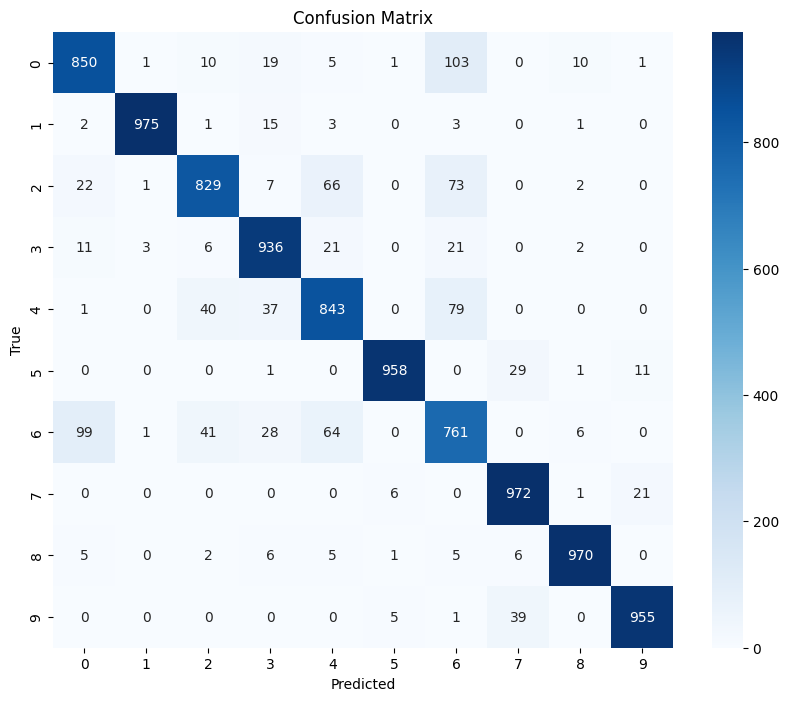

In [16]:
# Call the function to get the accuracy on test set and confusion matrix
saved_nn = LeNet_model()
saved_nn.load_state_dict(torch.load('saved_model.pth'))

# Evaluate the model and show the confusion matrix
test_accuracy = evaluate_confusion_matrix(saved_nn, loaders['test'], label_nr = 10)

### 7. Is LeNet better than the fully connected Neural Network trained in the project from lecture 3? Comment on the results

Answer:

* The **LeNet architecture reaches a test accuracy of 0.9053** at the 16th epoch
* Early stopping indicates that no further training is required. The gap between the validation and training loss curve increases with increasing epoch indicating overfitting. Further the curves get more flat with time.
* Data augmentation, regularization or other approaches could be applied to reduce overfitting and ensure that the trained model generalizes better. Therebey, higher results might be possible
* The **simple neural networks from Session 4** overall reached higher accuracy (over **97%**). However, it has to be noticed that **both tasks used significant different datasets.** The fashion mnist dataset is considered a much more difficult one compared to the mnist. Thus, it is hard to compare the created models.
* Also, the **LeNet results indicate strong generalization** as the accuracies between training, validation and test set are very close to each other.

In **general** CNN architectures are especially useful in image recoginition tasks. Reasons for that are:
* CNNs have convolutional layers where each layer applies a set of learnable filters to the input data. These filters act as feature detectors and automatically learn important features at different levels of abstraction. Convolutional layers allow CNNs to learn hierarchical representations of the image, capturing both low-level features (e.g., edges) and high-level features (e.g., complex shapes).
*  CNNs use shared weights across the entire image, which means the same set of filters is applied at different locations in the input image. This parameter sharing helps the network generalize better, as it can detect similar patterns in different parts of the image. Fully connected Neural Networks do not have this feature, and they require more parameters, making them prone to overfitting when dealing with images.
* After convolutional layers, CNNs often use pooling layers to downsample the feature maps and reduce the spatial dimensions. Pooling helps in reducing the computational complexity and makes the network more robust to variations in object positions and scales in the input image.
* CNNs are designed to capture spatial hierarchies in images. Lower layers detect simple patterns, and higher layers combine them to detect more complex and abstract features. This hierarchical representation allows CNNs to understand the context and spatial relationships between features in an image, which is critical for image classification.

* To the contrary, in a fully connected neural networks each neuron in one layer is connected to every neuron in the subsequent layer. This means that the output of each neuron in a layer becomes an input to every neuron in the next layer
* This type of architecture might be better suited for more general tasks or larger datasets. Especially for non-image data it would be the better choice.

## Sub-project 2:

## Use a pretrained model to solve

In this project you will download the Intel Image Classification dataset (https://www.kaggle.com/puneet6060/intel-image-classification/download).
Find a suitable pretrained Convolutional Neural Network and its weights. Fix the filters and retrain/finetune the top of the network. Show and comment on resuls.

Alternativelly, you can browse Kaggle for some interesting datasets like: Dogs vs Cats, Alien vs Predator, Doom vs Animal Crossing, CelebA, etc. Just don't use something easy like MNIST, Fashion-MNIST, etc.

The following pretrained model has been choosen: **ResNet-18** (Residual Network-18) is a  CNN architecture that was introduced to address the vanishing gradient problem in deep neural networks. It is widely used for image classification tasks and has become a benchmark architecture in computer vision.

It has **18 layers**. A pretrained version of the network is used that has learned feature representations by already beeing exposted to a wide range of images. The **input images are required to have a size of 224-by-224**.

### 1. Download the data

In [17]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

# Define the data directories
train_dir = '/content/drive/MyDrive/AppliedAI_LM/Linda/Data/seg_train/'
test_dir = '/content/drive/MyDrive/AppliedAI_LM/Linda/Data/seg_test/seg_test/'

# Load the data using ImageFolder
ds_train = datasets.ImageFolder(train_dir)
ds_test = datasets.ImageFolder(test_dir)

Mounted at /content/drive


In [18]:
# Check the identified number of classes (based on subfolders in train_dir and test_dir)
classes_count_train = len(ds_train.classes)
print("Number of classes in the training set:", classes_count_train)
classes_count_test = len(ds_test.classes)
print("Number of classes in the test set:", classes_count_test)

Number of classes in the training set: 6
Number of classes in the test set: 6


### 2. Preprocess the data.

(This might include resizing, augmenting, etc.)




In [19]:
# Define the transformations
size = (224, 224)  # Resize images to size required by Resnet18

data_transform = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(), # randomly horizontal flip images
        transforms.RandomRotation(10), # randomly rotate images
        transforms.Resize(size), # resize to previously defined size
        transforms.ToTensor(), # create tensor
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # nromalize to -1, 1
    ]),
    'test': transforms.Compose([
        transforms.Resize(size), # same steps exlcuding Augmenation (flipping & rotation) as test set should be unprocessed
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

In [20]:
# Apply transformation
ds_train.transform = data_transform['train']
ds_test.transform = data_transform['test']

### 3. Split the data (train / test / validation) and make mini-batches.

In [21]:
# Split the training dataset into training and validation subsets (test set already exists)
validation_split = 0.2

train_size = int(len(ds_train) * (1 - validation_split)) # get size of training set
validation_size = len(ds_train) - train_size #  get size of validation set
ds_train2, ds_val2 = random_split(ds_train, [train_size, validation_size]) # randomly split ds_train into ds_train and ds_val

In [22]:
# Create mini-batches
batch_size = 64

# Define the dataloaders
train_loader = DataLoader(ds_train2, batch_size=batch_size, shuffle=True, num_workers=2)
validation_loader = DataLoader(ds_val2, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=2)

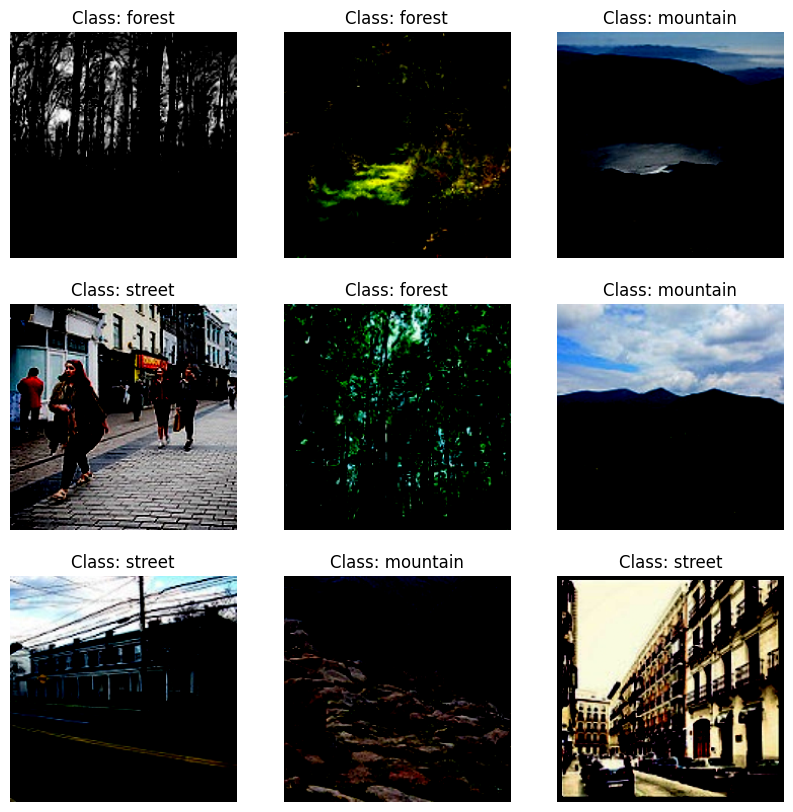

In [23]:
# Create a function to display random images of subsets
def visualize_random_images(loader, dataset):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        rand_idx = np.random.randint(len(dataset))
        image, label = dataset[rand_idx]
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f"Class: {dataset.classes[label]}")
        plt.axis('off')
    plt.show()

# Visualize random test images
visualize_random_images(test_loader, ds_test)

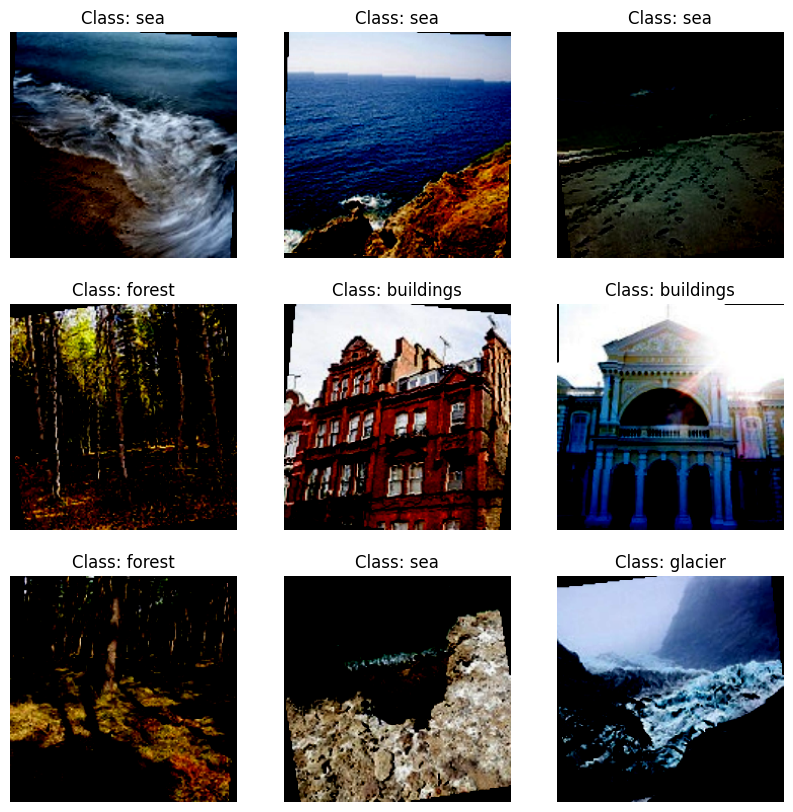

In [24]:
# Visualize random training images
visualize_random_images(train_loader, ds_train)

### 4. Download the pretrained architecture and weights.

This part might include some research and understanding of architecures and the type of data they were trained on.

In [25]:
import torchvision.models as models

# Download pre-trained ResNet-18
resnet18 = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 258MB/s]


### 5. Build the larger model that includes the pre-trained part and prepare it for training.

* Show the model summary so you are sure which components are included and how many (un)trainable parameters you have

In [26]:
import torch.nn as nn

# Freeze all layers in the pre-trained ResNet-18
for param in resnet18.parameters():
    param.requires_grad = False

# Modify the classifier (top) part of the model
resnet18.fc = nn.Linear(resnet18.fc.in_features, classes_count_train)

In [27]:
import torch.optim as optim
import torchsummary

# Move the model to the same device (GPU)
resnet18.to("cuda:0")

# Move the input_size to the same device
input_size = (3, 224, 224)
input_size = tuple(x for x in input_size)
input_size = tuple(x.to("cuda:0") if isinstance(x, torch.Tensor) else x for x in input_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.fc.parameters(), lr=0.001)

# Show model summary
torchsummary.summary(resnet18, input_size=input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

### 6. Train the trainable part of the model

In [28]:
# Define hyperparameters
learning_rate = 0.001
num_epochs = 30
early_stopping_patience = 5


# Apply previously created train function to train the model
train_losses_resnet, val_losses_resnet, train_accuracies_resnet, val_accuracies_resnet, best_val_accuracy_resnet, best_epoch_resnet = train(resnet18, {
    'train': train_loader,
    'validation': validation_loader
}, learning_rate = learning_rate, num_epochs = num_epochs, early_stopping_patience =early_stopping_patience )

Epoch 1
Training Loss: 0.6698577871376817
Validation Loss: 0.39289880950342526
Training Accuracy: 0.7939788011044803
Validation Accuracy: 0.8756679729248308
-------------------
Epoch 2
Training Loss: 0.37590722798962484
Validation Loss: 0.35826888240196486
Training Accuracy: 0.8767257504230872
Validation Accuracy: 0.8731742073387959
-------------------
Epoch 3
Training Loss: 0.3375001867217096
Validation Loss: 0.3309477571059357
Training Accuracy: 0.8840295715685401
Validation Accuracy: 0.8810117563234771
-------------------
Epoch 4
Training Loss: 0.3102966338734735
Validation Loss: 0.31267484243620525
Training Accuracy: 0.8886612630266322
Validation Accuracy: 0.8927680798004988
-------------------
Epoch 5
Training Loss: 0.3005364879711785
Validation Loss: 0.3023038465868343
Training Accuracy: 0.8955197292241917
Validation Accuracy: 0.8924118275739223
-------------------
Epoch 6
Training Loss: 0.2923913554881107
Validation Loss: 0.29687291756272316
Training Accuracy: 0.895430658234613


### 7. Show the training plots and confusion matrix

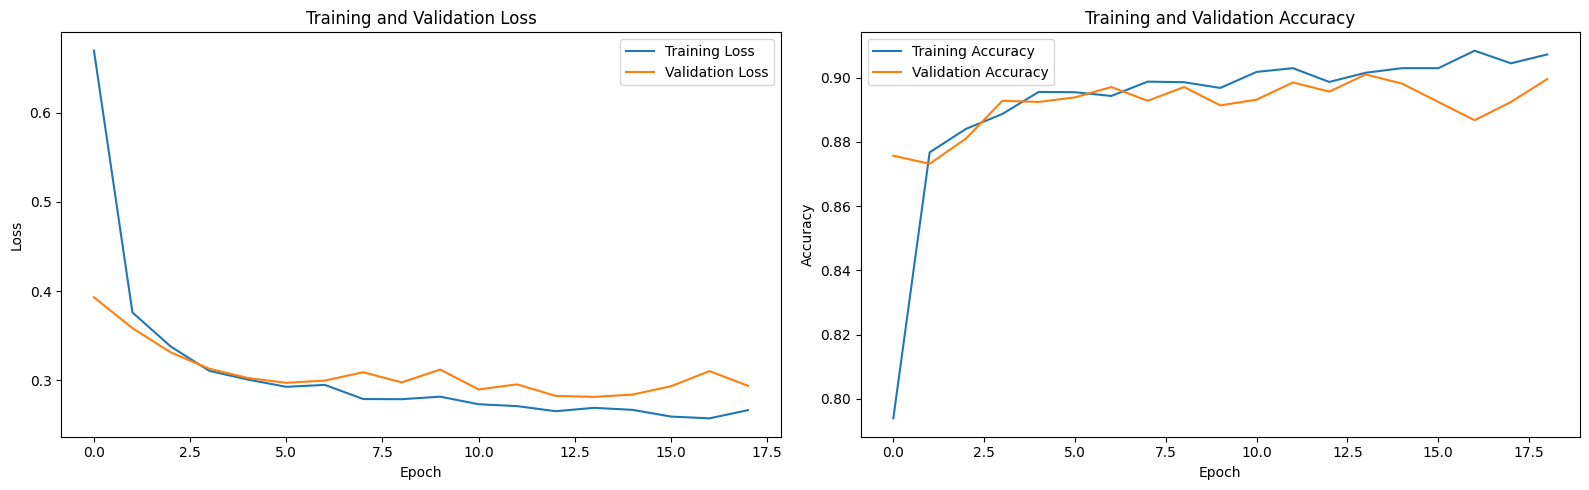

In [29]:
# Training plots
plot_training_curve(train_losses_resnet, val_losses_resnet, train_accuracies_resnet, val_accuracies_resnet)

Test accuracy: 0.906


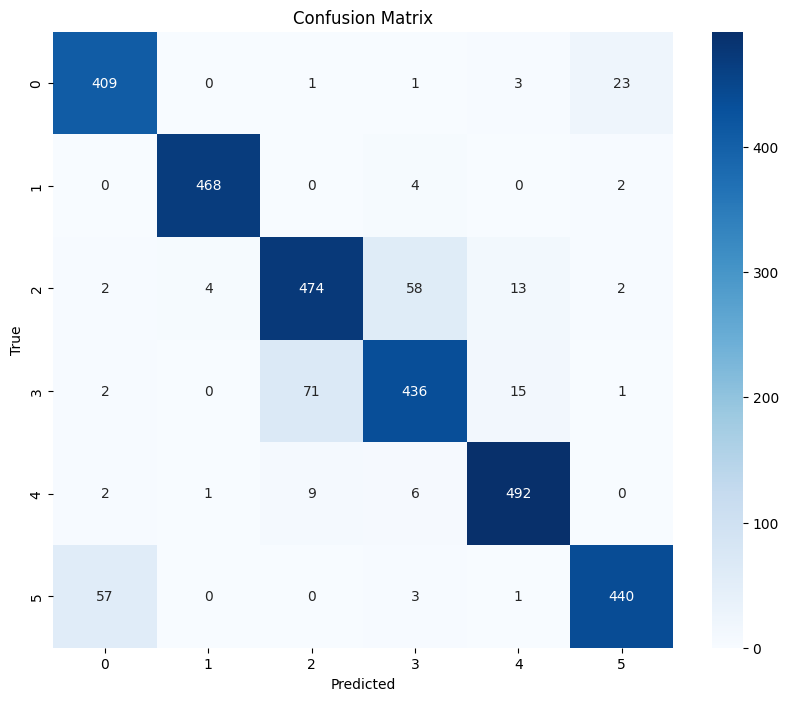

In [30]:
# Test Accuracy and Confusion Matrix
saved_Resnet18 = models.resnet18()
saved_Resnet18.fc = nn.Linear(resnet18.fc.in_features, classes_count_train)
saved_Resnet18.load_state_dict(torch.load('saved_model.pth'))

# Evaluate the model and show the confusion matrix
test_accuracy_resnet = evaluate_confusion_matrix(saved_Resnet18, test_loader, label_nr = 6)

### 8. Finetune the model and show the plots, test data confusion matrix and accuracy.

In [31]:
# Unfreeze all the layers in model so that weights get updated for fine-tuning
for param in resnet18.parameters():
    param.requires_grad = True

# Move the model to the same device (GPU)
resnet18.to("cuda:0")

# Move the input_size to the same device
input_size = (3, 224, 224)
input_size = tuple(x for x in input_size)
input_size = tuple(x.to("cuda:0") if isinstance(x, torch.Tensor) else x for x in input_size)

# Create optimizer
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.0001)

# Define hyperparameters
learning_rate = 0.0001
num_epochs = 30
early_stopping_patience = 5

# Apply previously created train function to train the model
train_losses_resnet_finetune, val_losses_resnet_finetune, train_accuracies_resnet_finetune, val_accuracies_resnet_finetune, best_val_accuracy_resnet_finetune, best_epoch_resnet_finetune = train(resnet18, {
    'train': train_loader,
    'validation': validation_loader
}, learning_rate = learning_rate, num_epochs = num_epochs, early_stopping_patience =early_stopping_patience )

Epoch 1
Training Loss: 0.2725924406920306
Validation Loss: 0.24511432478373701
Training Accuracy: 0.9089694486505745
Validation Accuracy: 0.9209120057000356
-------------------
Epoch 2
Training Loss: 0.1565251126832498
Validation Loss: 0.2668246050280603
Training Accuracy: 0.9426382827113209
Validation Accuracy: 0.9162807267545422
-------------------
Epoch 3
Training Loss: 0.10948289513841948
Validation Loss: 0.24247531093318353
Training Accuracy: 0.9608087645853746
Validation Accuracy: 0.9226932668329177
-------------------
Epoch 4
Training Loss: 0.09334720502374694
Validation Loss: 0.239916190166365
Training Accuracy: 0.9664202369288323
Validation Accuracy: 0.9287495546847168
-------------------
Epoch 5
Training Loss: 0.06597974097927693
Validation Loss: 0.23991177569736133
Training Accuracy: 0.9764852587512247
Validation Accuracy: 0.9348058425365159
-------------------
Epoch 6
Training Loss: 0.05917504111527127
Validation Loss: 0.2972507413307374
Training Accuracy: 0.978266678542798

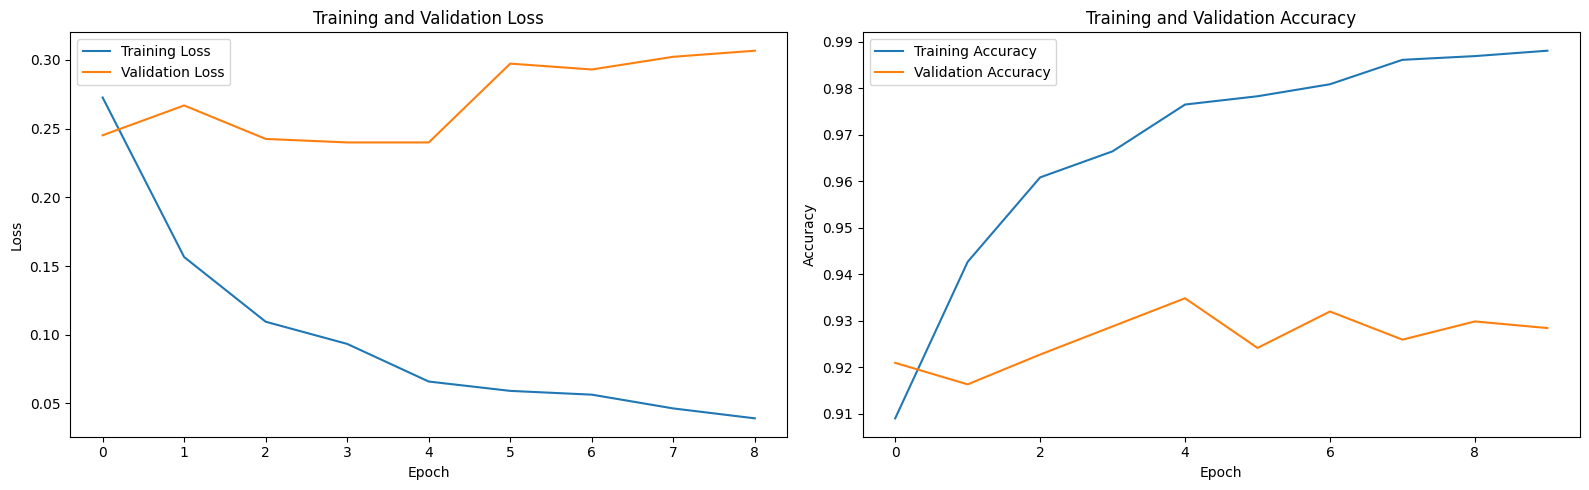

In [32]:
# Training plots
plot_training_curve(train_losses_resnet_finetune, val_losses_resnet_finetune, train_accuracies_resnet_finetune, val_accuracies_resnet_finetune)

Test accuracy: 0.929


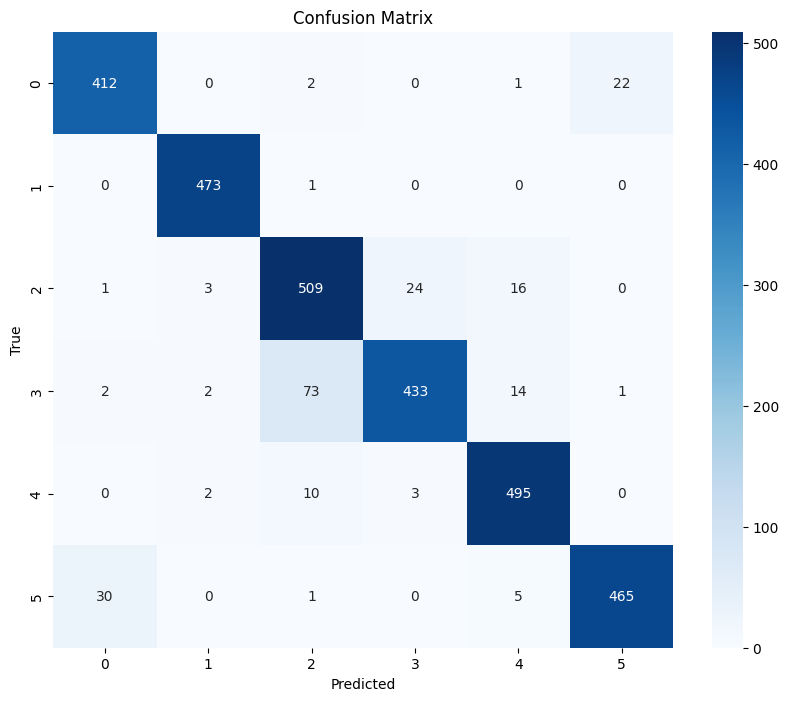

In [33]:
# Test Accuracy and Confusion Matrix
saved_Resnet18_finetune= models.resnet18()
saved_Resnet18_finetune.fc = nn.Linear(saved_Resnet18_finetune.fc.in_features, classes_count_train)
saved_Resnet18_finetune.load_state_dict(torch.load('saved_model.pth'))

# Evaluate the model and show the confusion matrix
test_accuracy_resnet_finetune = evaluate_confusion_matrix(saved_Resnet18_finetune, test_loader, label_nr = 6)

### 9. Comment on the results. Are the results to your satisfaction? Which phase contributed to the improved performance? What was the most challenging aspect of the exercise? Ideas for improving the model?

**RESULTS & SATISFACTION**

* The ResNet18 model achieves a test accuracy of 90.6%.
* The finetuned ResNet18 model achieves even better results with a test accuracy of 92.9%.
* This suggests that the transfer learning process, in which the pre-trained model's learned features are adapted to the new dataset, has enabled the fine-tuned model to leverage relevant domain-specific features and generalize better, resulting in improved classification performance. Additionally, fine-tuning may have acted as a form of regularization, preventing overfitting and leading to faster convergence during training.

* The learning curve of the ResNet18 model exhibits a rapid increase in performance for both validation and training. It then levels off within a certain interval. The spikes observed could be attributed to the chosen optimizer, Adam. The Adam optimizer utilizes adaptive learning rates for each parameter, potentially leading to sudden improvements or fluctuations in training. These spikes could indicate that the optimizer adjusts learning rates to facilitate the model's rapid progress towards a better solution. It's noteworthy that using SGD as an optimizer resulted in smoother curves but yielded worse performance (as shown below).
* The learning curve of the finetuned ResNet18 model initially appears as though it may not be learning effectively, given the large gap between the validation and test curves, and the lack of improvement in the validation curve with increasing epochs. However, it's important to consider that the accuracy started at a high level (over 90% for training and validation sets) from epoch 1. Consequently, the gap appears larger due to the y-axis starting at 90%. This aspect should be taken into consideration.

* Both models' confusion matrices reveal valuable insights. Notably, both models struggle with accurately predicting the number "3" and tend to misclassify it as "2". Additionally, the number "5" is often classified as "0". The non-finetuned model also frequently predicts the number "2" as "3". It seems that the finetuned model has been more successful in addressing these challenges.

* All in all, I am very happy with the results.

**IMPROVEMENT OF PERFORMANCE**

* Finetuning of the pretrained model led to increased accuracy.
* Employing a larger number of epochs with early stopping yielded improved performance while maintaining a tradeoff with running time.
* Both Stochastic Gradient Descent and Adam were tested as optimizers. Although SGD produced smoother learning curves, Adam resulted in higher overall test accuracy and was therefore chosen. Achieving good results with Adam required reducing the learning rate.

**CHALLENGES**

* Hyperparameter finetuning posed a significant challenge due to the extended running time, despite GPU usage.

**IDEAS FOR IMPROVEMENT**

* Exploring various Data Augmentation techniques and testing their effects could be beneficial. Such techniques artificially enhance the diversity and size of the training dataset by applying random transformations to the original data, potentially enhancing model generalization and robustness.
* Considering a deeper architecture such as ResNet-50, or even more advanced models like ResNet-101 or ResNet-152, could capture more intricate features.
* Ensemble Learning may be employed, involving training multiple ResNet-18 models with distinct initializations or data subsets, and then combining their predictions to enhance performance.
* Exploring optimization of the loss function is another avenue. While stochastic gradient descent and Adam were the only ones tested, tailored loss functions like focal loss or contrastive loss might be effective for your specific task.
* Leveraging k-fold cross-validation is a possibility. This technique divides the training dataset into k subsets, training and evaluating the model k times with each subset serving as the validation set once. It can provide a more reliable estimate of model performance.